In [5]:
import pandas as pd
import numpy as np

## Making sequence count data sets from pruned GISAID metadata

The `giasaid_metadata_pruned.tsv` is generated from the Nextstrain-curated GISAID metadata. Details for this can be found in `../data/README.md`.

In [6]:
# https://data.nextstrain.org/files/ncov/open/metadata.tsv.gz
raw_metadata_reader = pd.read_csv(
    "../data/gisaid_metadata_pruned.tsv", 
    sep="\t",
    usecols=(
        "strain",
        "date",
        "date_submitted",
        "country",
        "division",
        "Nextstrain_clade"
        ),
    dtype={
        "country": "category",
        "division": "category",
        "Nextstrain_clade": "category",
        },
    chunksize=100000)

In [7]:
# Countries of interest
locations = ["United Kingdom"]
start_date = "2021-09-01"
end_date = "2022-12-31"
end_forecast_period = "2023-01-31"

# Borrowing from John here
def clean_metadata(metadata):
    # Filter to countries
    metadata = metadata[metadata["country"].isin(locations)]
    
    # Remove ambigious dates
    unambiguous_dates = (metadata["date"] != "?") & (metadata["date"].str.count("-") == 2)
    unambiguous_dates = unambiguous_dates & ~(metadata["date"].str.contains("X", na=True))
    metadata = metadata[unambiguous_dates].copy()
    
    # Filter to date range
    metadata["date"] = pd.to_datetime(metadata["date"])
    metadata["date_submitted"] = pd.to_datetime(metadata["date_submitted"])

    date_since_start_date = (metadata["date"] >= start_date)
    date_before_end_date = (metadata["date"] <= end_forecast_period)
    metadata = metadata[(date_since_start_date) & (date_before_end_date)].copy()
        
    # Filter records without NS clade
    metadata = metadata[~pd.isnull(metadata["Nextstrain_clade"])].copy()
    
    return metadata

In [8]:
metadata_chunks = [clean_metadata(chunk) for chunk in raw_metadata_reader]

In [9]:
metadata = pd.concat(metadata_chunks, ignore_index=True)
metadata

,strain,date,date_submitted,country,division,Nextstrain_clade
0,Anguilla/105186/2021,2021-10-29,2021-12-07,United Kingdom,Anguilla,21J (Delta)
1,Anguilla/105187/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21J (Delta)
2,Anguilla/105188/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21J (Delta)
3,Anguilla/105189/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21G (Lambda)
4,Anguilla/105191/2021,2021-10-30,2021-12-07,United Kingdom,Anguilla,21J (Delta)
...,...,...,...,...,...,...
2066891,Wales/QEUH-3F941CA/2022,2022-09-06,2022-09-22,United Kingdom,Wales,22B (Omicron)
2066892,Wales/QEUH-3F94537/2022,2022-09-06,2022-09-22,United Kingdom,Wales,22B (Omicron)
2066893,Wales/UW21110991892/2021,2021-11-09,2022-04-20,United Kingdom,Wales,21J (Delta)
2066894,Wales/UW21111177316/2021,2021-11-11,2022-04-20,United Kingdom,Wales,21J (Delta)


In [10]:
# Map clade to variant
clade_to_variant = {"21A (Delta)" : "Delta", 
                    "21I (Delta)" : "Delta", 
                    "21J (Delta)" : "Delta", 
                    "21K (Omicron)" : "Omicron 21K", 
                    "21L (Omicron)" : "Omicron 21L", 
                    "22A (Omicron)" : "Omicron 22A", 
                    "22B (Omicron)" : "Omicron 22B", 
                    "22C (Omicron)" : "Omicron 22C",
                    "22D (Omicron)" : "Omicron 22D",
                    "22E (Omicron)" : "Omicron 22E",
                    "23A (Omicron)" : "Omicron 23A"}

metadata["variant"] = (metadata["Nextstrain_clade"]
                       .map(clade_to_variant)
                       .fillna("other")
                      )
metadata

,strain,date,date_submitted,country,division,Nextstrain_clade,variant
0,Anguilla/105186/2021,2021-10-29,2021-12-07,United Kingdom,Anguilla,21J (Delta),Delta
1,Anguilla/105187/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21J (Delta),Delta
2,Anguilla/105188/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21J (Delta),Delta
3,Anguilla/105189/2021,2021-10-28,2021-12-07,United Kingdom,Anguilla,21G (Lambda),other
4,Anguilla/105191/2021,2021-10-30,2021-12-07,United Kingdom,Anguilla,21J (Delta),Delta
...,...,...,...,...,...,...,...
2066891,Wales/QEUH-3F941CA/2022,2022-09-06,2022-09-22,United Kingdom,Wales,22B (Omicron),Omicron 22B
2066892,Wales/QEUH-3F94537/2022,2022-09-06,2022-09-22,United Kingdom,Wales,22B (Omicron),Omicron 22B
2066893,Wales/UW21110991892/2021,2021-11-09,2022-04-20,United Kingdom,Wales,21J (Delta),Delta
2066894,Wales/UW21111177316/2021,2021-11-11,2022-04-20,United Kingdom,Wales,21J (Delta),Delta


## Looking at submission delays?

In [11]:
metadata["submission_delay"] = (metadata["date_submitted"] - metadata["date"]).dt.days

Text(0.5, 0, 'Submission delay')

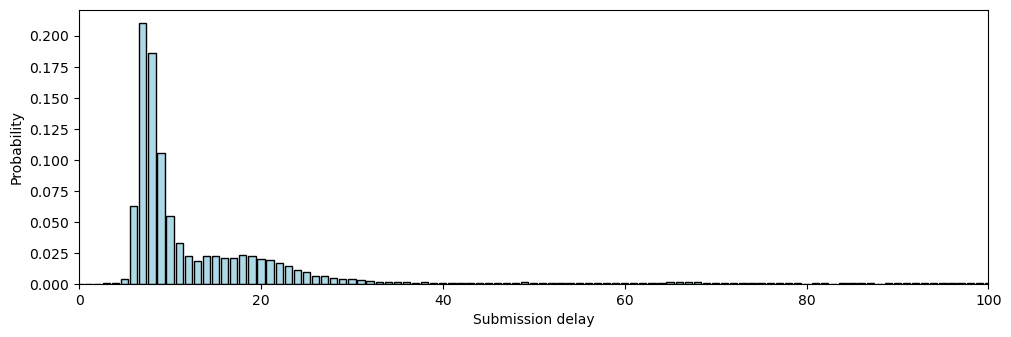

In [12]:
# Plot empirical distribution
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)
ax = fig.add_subplot(spec[0])

#ax.hist(metadata["submission_delay"].values, ec="k", bins=100, color="lightblue")
def to_pmf(submission_delays):
    n_max = submission_delays.max()
    pmf = np.zeros(n_max+1)
    
    for n in range(n_max+1):
        pmf[n] += (submission_delays == n).sum()
    pmf = pmf / submission_delays.shape[0]
    return pmf
    
empirical_pmf = to_pmf(metadata["submission_delay"].values) 
xs_delays = np.arange(empirical_pmf.shape[0])
ax.bar(xs_delays, empirical_pmf, color="lightblue", ec="k")
ax.set_xlim(0,100)
ax.set_ylabel("Probability")
ax.set_xlabel("Submission delay")

In [13]:
metadata.shape

(2066896, 8)

In [14]:
# Resampling metadata with empirical delay
def resample_submission_delays(metadata, pmf):
    """
    Given a pmf, resample submission dates for sequences with given pmf.
    """
    metadata_resample = metadata.copy()
    possible_delays = np.arange(pmf.shape[0])
    n_sequences = metadata.shape[0]
    submission_delays = np.random.choice(possible_delays, n_sequences, p=pmf)
    
    metadata_resample["submission_delay"] = submission_delays
    metadata_resample["date_submitted"] = metadata_resample["date"] + metadata_resample["submission_delay"].astype('timedelta64[D]') 
    return metadata_resample
    
metadata_empirical_resample = resample_submission_delays(metadata, empirical_pmf)
metadata_empirical_resample

,strain,date,date_submitted,country,division,Nextstrain_clade,variant,submission_delay
0,Anguilla/105186/2021,2021-10-29,2021-11-07,United Kingdom,Anguilla,21J (Delta),Delta,9
1,Anguilla/105187/2021,2021-10-28,2021-11-03,United Kingdom,Anguilla,21J (Delta),Delta,6
2,Anguilla/105188/2021,2021-10-28,2021-11-17,United Kingdom,Anguilla,21J (Delta),Delta,20
3,Anguilla/105189/2021,2021-10-28,2021-11-08,United Kingdom,Anguilla,21G (Lambda),other,11
4,Anguilla/105191/2021,2021-10-30,2021-11-07,United Kingdom,Anguilla,21J (Delta),Delta,8
...,...,...,...,...,...,...,...,...
2066891,Wales/QEUH-3F941CA/2022,2022-09-06,2022-09-27,United Kingdom,Wales,22B (Omicron),Omicron 22B,21
2066892,Wales/QEUH-3F94537/2022,2022-09-06,2022-09-28,United Kingdom,Wales,22B (Omicron),Omicron 22B,22
2066893,Wales/UW21110991892/2021,2021-11-09,2021-11-16,United Kingdom,Wales,21J (Delta),Delta,7
2066894,Wales/UW21111177316/2021,2021-11-11,2021-11-18,United Kingdom,Wales,21J (Delta),Delta,7


## Thresholding sequences submitted

In [16]:
def threshold_counts(metadata, max_sequences):
    metadata_thres = metadata.copy()
    
    # Sample n sequences at most without replacement
    def sample_n_at_most(x):
        if max_sequences >= x.shape[0]:
            return x
        else:
            return x.sample(n=max_sequences, replace=False)
    # Group by week and apply sample_n_at_most
    return (metadata_thres
            .groupby([pd.Grouper(key='date', freq='W')])
            .apply(sample_n_at_most)
            .reset_index(drop=True))

threshold_counts(metadata, 1000)

# Figure the actual average and then based on that
# 100, 500, 1000, 2000, empirical

# Look at averages for other countries!

# Basically need to pick maximum sequence counts and then loop over them
# Folder structure should be

# down_scaling/UK/thresholding/{date}/{sequence_counts}

,strain,date,date_submitted,country,division,Nextstrain_clade,variant,submission_delay
0,England/ALDP-1DAE4AE/2021,2021-09-05,2021-09-13,United Kingdom,England,21J (Delta),Delta,8
1,Scotland/QEUH-1D7E79F/2021,2021-09-03,2021-09-13,United Kingdom,Scotland,21J (Delta),Delta,10
2,England/QEUH-1DC10FC/2021,2021-09-05,2021-09-13,United Kingdom,England,21J (Delta),Delta,8
3,England/NORT-YYDMTC/2021,2021-09-02,2021-09-20,United Kingdom,England,21J (Delta),Delta,18
4,England/NEWC-1DA1793/2021,2021-09-05,2021-09-13,United Kingdom,England,21J (Delta),Delta,8
...,...,...,...,...,...,...,...,...
74995,England/BRBR-326B61F8/2023,2023-01-31,2023-02-08,United Kingdom,England,22D (Omicron),Omicron 22D,8
74996,England/QEUH-326C0155/2023,2023-01-31,2023-02-13,United Kingdom,England,22D (Omicron),Omicron 22D,13
74997,Wales/PHWC-PKM5CU/2023,2023-01-31,2023-02-22,United Kingdom,Wales,22E (Omicron),Omicron 22E,22
74998,England/LSPA-3268E84F/2023,2023-01-30,2023-02-01,United Kingdom,England,22E (Omicron),Omicron 22E,2


## Creating data sets as of given observation dates

In [34]:
def count_sequences_with_submission_date(metadata):    
    grouped = metadata.groupby(["date", "country", "variant"]) 
    
    def compute_delay(x):
        delays = (x["date_submitted"]
                  .value_counts(normalize=False)
                  .rename_axis('date_submitted')
                  .reset_index(name='sequences'))
        
        delays = delays.sort_values("date_submitted")
        return delays
    
    out = (grouped
           .apply(compute_delay)
           .reset_index()
           .drop(columns=["level_3"])
           .rename(columns={"country": "location"}))
    return out

delayed = count_sequences_with_submission_date(metadata)
delayed

,date,location,variant,date_submitted,sequences
0,2021-09-01,United Kingdom,Delta,2021-09-06,60
1,2021-09-01,United Kingdom,Delta,2021-09-08,1138
2,2021-09-01,United Kingdom,Delta,2021-09-09,911
3,2021-09-01,United Kingdom,Delta,2021-09-10,1134
4,2021-09-01,United Kingdom,Delta,2021-09-11,416
...,...,...,...,...,...
30956,2023-01-31,United Kingdom,other,2023-02-20,3
30957,2023-01-31,United Kingdom,other,2023-02-22,3
30958,2023-01-31,United Kingdom,other,2023-02-23,4
30959,2023-01-31,United Kingdom,other,2023-02-24,1


In [20]:
def observe_sequence_counts(delayed, obs_date=None):
    # Given an observation date as well as counts of sequences and their submission dates,
    # Reconstruct data available on observation date
    
    obs_seq = delayed.copy()
    
    # Filter to sequences submitted on or before date
    if obs_date:
        obs_seq = obs_seq[obs_seq["date_submitted"] < obs_date]
        
    # Sum across remaining sequences
    obs_seq = (obs_seq
     .groupby(["date", "location", "variant"])["sequences"]
     .sum()).reset_index()
    
    # Sort data
    obs_seq = obs_seq.sort_values(["location", "variant", "date"])
        
    # Remove entries with no observed sequences
    obs_seq = obs_seq[obs_seq["sequences"] > 0]
    
    return obs_seq

In [22]:
# Testing observation dates
#obs_seq = observe_sequence_counts(delayed, obs_date="2022-06-30")
#obs_seq.date.max()

In [26]:
def make_observation_dates(obs_interval=30):
    total_interval = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    ndays = np.arange(90 + 14, total_interval, obs_interval).astype(int)
    if total_interval not in ndays:
        ndays = np.append(ndays, total_interval)

    obs_dates = [pd.to_datetime(start_date) + pd.Timedelta(nday, 'd') for nday in ndays]
    obs_dates = [date.strftime("%Y-%m-%d") for date in obs_dates]
    return obs_dates

def make_observation_dates():
    # Alternatively, do 1st of each month
    obs_dates = []
    for m in range(1, 13):
        for d in ["01"]:
            obs_dates.append(f"2022-{m:02}-{d}")
    return obs_dates

In [27]:
obs_dates = make_observation_dates()
obs_dates

['2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2022-12-01']

In [28]:
# Make data sets
import os 

# Make thresholded data sets
thresholds = [100, 500, 1000, 2000, 5000, 1e10]
delayed_thres = {}
for thres in thresholds:
    metadata_thres = threshold_counts(metadata, thres)
    delayed_thres[str(thres)] = count_sequences_with_submission_date(metadata_thres)

In [36]:
# Observe data sets at different dates
def filter_dates(obs_seq, obs_date):
    # Filter to most recent 104 days
    min_date = (pd.to_datetime(obs_date) - pd.Timedelta(90 + 14,'d'))
    obs_seq = obs_seq[obs_seq.date > min_date]
    
    # Remove most recent 14 days due to bias
    max_date = (pd.to_datetime(obs_date) - pd.Timedelta(14,'d'))
    obs_seq = obs_seq[obs_seq.date <= max_date]
    return obs_seq

for date in obs_dates:
    # Observe sequence counts for each threshold and then concat
    obs_seqs = []
    for thres in thresholds:
        delayed = delayed_thres[str(thres)] # Counts of delays
        obs_seq = observe_sequence_counts(delayed, obs_date=date)
        obs_seq["thres"] = thres # Add column with threshold for simplicity
        obs_seqs.append(obs_seq)
    obs_seqs = pd.concat(obs_seqs)
    
    # Export files
    path = "../data/down_scaled/thresholding/" + date
    if not os.path.exists(path):
        os.makedirs(path)
    obs_seqs.to_csv(f"{path}/seq_counts_{date}.tsv", sep="\t", index = False)

In [35]:
# Get final truth sets
delayed = count_sequences_with_submission_date(metadata)
obs_seq = observe_sequence_counts(delayed, obs_date=None)

# Make sure we have the folder
path = "../data/down_scaled/truth"
if not os.path.exists(path):
        os.makedirs(path)
        
obs_seq.to_csv(f"{path}/seq_counts_truth.tsv", sep="\t", index = False)